In this notebook we preprocess baseball data into time series data, which we export to multi-class classification models predicting the pitch outcome of a given pitcher, called events in pybaseball. We do a train-test split with validation.

In [136]:
# Importing libraries
import pybaseball
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Enable cache because importing pybaseball is a large query
pybaseball.cache.enable()

We consider consecutive sequences of pitches of length pitch_sequence_length. Our objective is to predict the last pitch outcome in the sequence using the previous pitch_sequence_length-1 pitches.

In [137]:
pitch_sequence_length=21

Upload the data.

In [138]:
train_start = '2023-05-01'
train_end = '2023-06-01'

val_start = '2024-05-01'
val_end = '2024-06-01'

test_start = '2025-05-01'
test_end = '2025-06-01'

# Train-test split with validation
train_data = pybaseball.statcast(start_dt=train_start, end_dt=train_end, verbose=True)
val_data = pybaseball.statcast(start_dt=val_start, end_dt=val_end, verbose=True)
test_data = pybaseball.statcast(start_dt=test_start, end_dt=test_end, verbose=True)

print(len(train_data), len(val_data), len(test_data))

This is a large query, it may take a moment to complete


100%|██████████| 32/32 [00:04<00:00,  7.88it/s]


This is a large query, it may take a moment to complete


100%|██████████| 32/32 [00:03<00:00,  8.30it/s]


This is a large query, it may take a moment to complete


100%|██████████| 32/32 [00:03<00:00,  8.35it/s]


124382 123138 124433


In [139]:
# Remove any possible duplicate rows
train_data = train_data.drop_duplicates()
val_data = val_data.drop_duplicates()
test_data = test_data.drop_duplicates()

print(len(train_data), len(val_data), len(test_data))

124382 123138 124433


In [140]:
print('Size of all data:', len(train_data) + len(val_data) + len(test_data))

Size of all data: 371953


In [141]:
# New pitch data row is added to the top of the dataframe. Here we see this for a specific pitcher.
specific_pitcher_data = train_data[train_data['pitcher'].isin([605447])].copy()
print('Data for pitcher with ID 605447')
print(specific_pitcher_data[['pitcher', 'game_date', 'at_bat_number', 'pitch_number']].head(20))

# Sort the pitching data in increasing time order by reversing the order of the rows
print('Sorted pitch data')
sorted_specific_pitcher_data = specific_pitcher_data[::-1]
print(sorted_specific_pitcher_data[['pitcher', 'game_date', 'at_bat_number', 'pitch_number']].head(20))

Data for pitcher with ID 605447
      pitcher  game_date  at_bat_number  pitch_number
1363   605447 2023-06-01             68             4
1433   605447 2023-06-01             68             3
1484   605447 2023-06-01             68             2
1536   605447 2023-06-01             68             1
1553   605447 2023-06-01             67             1
1627   605447 2023-06-01             66             6
1699   605447 2023-06-01             66             5
1754   605447 2023-06-01             66             4
1808   605447 2023-06-01             66             3
1863   605447 2023-06-01             66             2
1919   605447 2023-06-01             66             1
1940   605447 2023-06-01             65             1
2668   605447 2023-05-28             69             4
2802   605447 2023-05-28             69             3
2918   605447 2023-05-28             69             2
3020   605447 2023-05-28             69             1
3163   605447 2023-05-28             68           

Order the rows by increasing time and add pitch count feature to train, validation, test data.

In [142]:
# Reorder the rows of pitching data by increasing time
train_data = train_data[::-1]
val_data = val_data[::-1]
test_data = test_data[::-1]

# Pitch count (or cumulative pitch number) of any pitch within a game
train_data.loc[:, 'pitch_count'] = train_data.groupby(['game_pk', 'pitcher']).cumcount() + 1
val_data.loc[:, 'pitch_count'] = val_data.groupby(['game_pk', 'pitcher']).cumcount() + 1
test_data.loc[:, 'pitch_count'] = test_data.groupby(['game_pk', 'pitcher']).cumcount() + 1

Define the set of relevant features.

In [143]:
categorical_features = [
    'events',
    'pitcher',
    'batter',
    'pitch_type'
]

counting_features = [
    'pitch_count',
    'inning',
    'balls', 'strikes',
    'home_score', 'away_score', 'bat_score', 'fld_score',
    'post_home_score', 'post_away_score', 'post_bat_score'
]

continuous_features = [
    'release_speed',
    'release_pos_x',
    'release_pos_z',
    'vx0', 'vy0', 'vz0',
    'ax', 'ay', 'az',
    'effective_speed'
]

sorting_features = ['game_date', 'at_bat_number', 'pitch_number']

The number of features num_features excludes the 3 sorting features because these are auxiliary features used only to create sliding windows of pitches and which are immediately discarded after use.

In [144]:
num_features = len(categorical_features) + len(counting_features) + len(continuous_features)
print(num_features)

25


In [145]:
print('Categorical features')
print(train_data[categorical_features].head())

print('Counting features')
print(train_data[counting_features].head()) # the backslash \ in the printed data frame indicates the table is continued in the next line

print('Continuous features')
print(train_data[continuous_features].head())

print('Sorting features')
print(train_data[sorting_features].head())

Categorical features
         events  pitcher  batter pitch_type
2298  field_out   664062  681082         FF
2216       None   664062  607208         FF
2150       None   664062  607208         SL
2089       None   664062  607208         FS
2023       None   664062  607208         FF
Counting features
      pitch_count  inning  balls  strikes  home_score  away_score  bat_score  \
2298            1       1      0        0           0           0          0   
2216            2       1      0        0           0           0          0   
2150            3       1      0        1           0           0          0   
2089            4       1      1        1           0           0          0   
2023            5       1      1        2           0           0          0   

      fld_score  post_home_score  post_away_score  post_bat_score  
2298          0                0                0               0  
2216          0                0                0               0  
2150        

Clean the training, validation, and testing data by removing columns which are deprecated or have no relation with pitch outcome, followed by removing rows which contain nan values. 

In [146]:
def data_cleaner(data):
    # Only keep games occuring in the R=Regular Season, F=wild card, L=League Championship Series, W=World Series
    data = data[data['game_type'].isin(['R', 'F', 'L', 'W'])].copy()

    # Keep only relevant features
    relevant_data=data.loc[:, categorical_features + counting_features + continuous_features + sorting_features]

    # Remove rows with any nan or None values
    clean_data = relevant_data.dropna().copy()
    
    # Below we set the appropriate data types for each column of the DataFrame data. 
    # Keep in mind that pandas still stores these data types as objects, 
    # so when we convert to arrays we need to explicitly set their data types again
    
    # Change all categorical features to string to put them on uniform footing
    clean_data.loc[:, categorical_features] = clean_data[categorical_features].astype(str)

    # Make sure continuous features are float32
    clean_data.loc[:, continuous_features] = clean_data[continuous_features].astype('float32')
    
    # Change count features to float32 to put them on the same footing as continuous features
    clean_data.loc[:, counting_features] = clean_data[counting_features].astype('float32')
    
    return(clean_data)

In [147]:
# Clean train, validation, and test
clean_train = data_cleaner(train_data)
clean_val = data_cleaner(val_data)
clean_test = data_cleaner(test_data)

In [148]:
print(clean_train.shape, clean_val.shape, clean_test.shape)
print(clean_train[categorical_features].values.dtype)
print(clean_train[continuous_features].values.dtype)

(31830, 28) (31593, 28) (32003, 28)
object
object


Plot relative frequencies of each pitch outcome in training data.

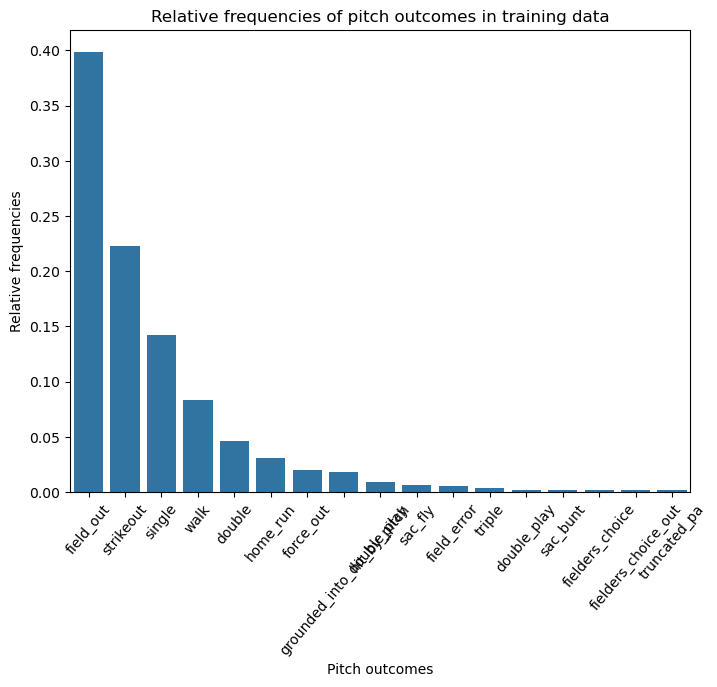

In [149]:
rel_freq = clean_train['events'].value_counts() / len(clean_train)

threshold = 0.001
# Filter out relative frequencies below the threshold
filtered_rel_freq = rel_freq[rel_freq >= threshold] 


plt.figure(figsize=(8,6))
sns.barplot(x=filtered_rel_freq.index, y=filtered_rel_freq.values)
plt.title('Relative frequencies of pitch outcomes in training data')
plt.xlabel('Pitch outcomes')
plt.ylabel('Relative frequencies')
plt.xticks(rotation=50)
plt.show()

Filter out rare pitch outcomes from training, validation, and testing data, and make sure that these three data sets cover all remaining pitch outcomes.

In [150]:
# Set top 11 pitch outcomes we will work with
pitch_outcomes = [
    'field_out',
    'strikeout',
    'single',
    'walk',
    'double',
    'home_run',
    'force_out',
    'grounded_into_double_play',
    'hit_by_pitch',
    'sac_fly',
    'triple'
]
num_classes = len(pitch_outcomes) # Number of classes for multiclass classification models
print(num_classes)

11


In [151]:
# Make sure training, validation, and testing data contain all possible pitch outcomes before filtering
print(
    set(pitch_outcomes) <= set(clean_train['events'].unique()),
    set(pitch_outcomes) <= set(clean_val['events'].unique()),
    set(pitch_outcomes) <= set(clean_test['events'].unique())
)

True True True


In [152]:
# Filter out events not contained in pitch_outcomes
filtered_clean_train = clean_train[clean_train['events'].isin(pitch_outcomes)].copy()
filtered_clean_val = clean_val[clean_val['events'].isin(pitch_outcomes)].copy()
filtered_clean_test = clean_test[clean_test['events'].isin(pitch_outcomes)].copy()

print(filtered_clean_train.shape, filtered_clean_val.shape, filtered_clean_test.shape)

# Label encode categorical features
label_encoders = {} # Dictionary of label encoders for each categorical feature
for cat_feature in categorical_features:
    all_labels = pd.concat([filtered_clean_train[cat_feature], filtered_clean_val[cat_feature], filtered_clean_test[cat_feature]], axis=0)
    
    label_encoder = LabelEncoder()
    label_encoder.fit(all_labels)
    label_encoders[cat_feature] = label_encoder

    filtered_clean_train[cat_feature] = label_encoder.transform(filtered_clean_train[cat_feature])
    filtered_clean_val[cat_feature] = label_encoder.transform(filtered_clean_val[cat_feature])
    filtered_clean_test[cat_feature] = label_encoder.transform(filtered_clean_test[cat_feature])

(31286, 28) (31023, 28) (31447, 28)


In [153]:
print(label_encoders['events'].classes_)
print(len(pitch_outcomes))
print(filtered_clean_train['events'].head())

['double' 'field_out' 'force_out' 'grounded_into_double_play'
 'hit_by_pitch' 'home_run' 'sac_fly' 'single' 'strikeout' 'triple' 'walk']
11
2298    1
1877    8
1733    1
1762    8
1543    8
Name: events, dtype: int64


Standardize the continuous features using mean and standard deviation of training features.

In [154]:
# Compute mean and standard deviation of each feature, i.e. column) in train
train_standard_scaler = StandardScaler()
std_train = filtered_clean_train.copy()

# Standardize train using mean and standard deviation of train features
std_train[continuous_features] = train_standard_scaler.fit_transform(filtered_clean_train[continuous_features])

# Standardize validation using mean and standard deviation of train features
std_val = filtered_clean_val.copy()
std_val[continuous_features] = train_standard_scaler.fit_transform(filtered_clean_val[continuous_features])

# Standardize test using mean and standard deviation of train features
std_test = filtered_clean_test.copy()
std_test[continuous_features] = train_standard_scaler.transform(filtered_clean_test[continuous_features])

In [155]:
print(std_train.head())

      events  pitcher  batter  pitch_type  pitch_count  inning  balls  \
2298       1      510     579           6            1       1      0   
1877       8      510     146           8            7       1      1   
1733       1      510     284           8           10       1      1   
1762       8      135     133           6            9       1      3   
1543       8      135      24           6           13       1      0   

      strikes  home_score  away_score  ...       vx0       vy0       vz0  \
2298        0           0           0  ...  0.296284 -0.346621 -0.967978   
1877        2           0           0  ...  0.219155  1.112271  0.050235   
1733        1           0           0  ...  0.327825  0.936057  0.381116   
1762        2           0           0  ...  0.951145 -0.973218 -1.987059   
1543        2           0           0  ...  0.564143 -0.891151 -0.749130   

            ax        ay        az  effective_speed  game_date  at_bat_number  \
2298 -0.694244  0.46199

In [156]:
print(std_train.shape, std_val.shape, std_test.shape)

(31286, 28) (31023, 28) (31447, 28)


Obtain the collection of all sliding window sequences of pitches per pitcher.

In [157]:
# Input std_data is a DataFrame of shape (number of pitches, 25 features + 3 sorting features)
# Output is 3D array of shape (number of windows per pitcher, window size, input size=28 - 3 features)
def pitch_sequences(std_data, window_size):
# Group the data by pitchers
    groups = std_data.groupby('pitcher')

    # Create sliding windows of pitches per pitcher
    pitch_sequence_list=[]
    for _, group in groups:
        # Sort pitches (note that sort_values by default is ascending sorting order, i.e. lexicographic)
        group = group.sort_values(by=sorting_features)
        
        # Remove sorting features since their only purpose is for creating sliding windows
        group = group.drop(columns=sorting_features) 
                
        for i in range(len(group) - window_size + 1):
            window = group.iloc[i:i + window_size]
            pitch_sequence_list.append(window.values)
            
    pitch_sequences = np.stack(pitch_sequence_list, axis=0)
    return(pitch_sequences)

In [158]:
train_pitch_sequences=pitch_sequences(std_train, pitch_sequence_length)
val_pitch_sequences=pitch_sequences(std_val, pitch_sequence_length)
test_pitch_sequences=pitch_sequences(std_test, pitch_sequence_length)

In [159]:
print(train_pitch_sequences.shape)
print(val_pitch_sequences.shape)
print(test_pitch_sequences.shape)

(21251, 21, 25)
(21367, 21, 25)
(21646, 21, 25)


Extract labels and setup for model training and testing. All pairs (X,y) below have the following shape: X has shape (number of sequences, pitch_sequence_length-1, input_size=num_features=25) and y has shape (number of sequences,).

In [160]:
# Training, validation, and testing arrays
X_train = train_pitch_sequences[:, :-1, :].astype('float32') # Remove the last pitch sequence
y_train = train_pitch_sequences[:, -1, 0].astype(int) # For every pitch sequence, take the event of the last pitch data

X_val = val_pitch_sequences[:, :-1, :].astype('float32')
y_val = val_pitch_sequences[:, -1, 0].astype(int)

X_test = test_pitch_sequences[:, :-1, :].astype('float32')
y_test = test_pitch_sequences[:, -1, 0].astype(int)


In [161]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(21251, 20, 25) (21251,)
(21367, 20, 25) (21367,)
(21646, 20, 25) (21646,)


Export data.

In [162]:
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)

np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)

np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

In [163]:
data_parameters = np.array([pitch_sequence_length, num_classes, num_features])
np.save('data_parameters.npy', data_parameters)

For models like XGBoost and Random Forest, we do not care about the time series aspect of the data, so flatten X into a 2D array of shape (number of sequences, total_num_features=(pitch_sequence_length - 1) * num_features).

In [164]:
flat_X_train=X_train.reshape(X_train.shape[0], -1)
flat_X_val=X_val.reshape(X_val.shape[0], -1)
flat_X_test=X_test.reshape(X_test.shape[0], -1)

print(flat_X_train.shape, flat_X_val.shape, flat_X_test.shape)

(21251, 500) (21367, 500) (21646, 500)


In [165]:
np.save('flat_X_train.npy', flat_X_train)
np.save('flat_X_val.npy', flat_X_val)
np.save('flat_X_test.npy', flat_X_test)

In [166]:
flat_num_features = (pitch_sequence_length - 1) * num_features
print(flat_num_features)

500


In [167]:
flat_data_parameters = np.array([pitch_sequence_length, num_classes, flat_num_features])
np.save('flat_data_parameters.npy', flat_data_parameters)